In [23]:
from pathlib import Path
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

INNER_DIR = Path("../target/criterion/corrset-inner")
INNER_LEVELS = [
    "0_naive",
    "1_indexed",
    "2_imap",
    "3_bchecks",
    "4_bitset",
    "5_simd",
    "6_alloc"
]

OUTER_DIR = Path("../target/criterion/corrset-outer")
OUTER_LEVELS = [
    "0_serial",
    "1_parallel",
    "2_batched",
]

def fmt_runtime(runtime):
    units = [
        (1e-6, 'μs'),
        (1e-3, 'ms'),
        (1, 's'),
        (60, 'min'),
        (60*60, 'hr'),
        (60*60*24, 'days'),
        (60*60*24*365, 'years')
    ]

    for (threshold, unit) in reversed(units):
        if runtime > threshold:
            return f'{runtime/threshold:.2f} {unit}'
    return f'{runtime:,.2f}ns'

def fmt_speedup(speedup):
    return f'{speedup:,.2f}×'

def est_total_time_inner(runtime):
    return 2535650040 * runtime

def load_metrics(dir, levels, est, init=None):
    metrics = init or []
    for level in levels:
        estimates = json.load((dir / level / "new" / "estimates.json").open())
        runtime = estimates['mean']['point_estimate'] / 1e9
    
        rel_speedup = metrics[-1]["runtime"] / runtime if len(metrics) > 0 else None
        abs_speedup = metrics[0]["runtime"] / runtime if len(metrics) > 0 else None
        
        metrics.append({
            'level': level,
            'runtime': runtime,
            "rel_speedup": rel_speedup,
            "abs_speedup": abs_speedup,
            "est_total_time": est(runtime),
        })
        
    return pd.DataFrame(metrics)

def print_table(df):
    df['runtime_fmt'] = df.runtime.map(fmt_runtime)
    df['rel_speedup_fmt'] = df.rel_speedup.map(fmt_speedup)
    df['abs_speedup_fmt'] = df.abs_speedup.map(fmt_speedup)
    df['est_total_time_fmt'] = df.est_total_time.map(fmt_runtime)
    print(df[['level', 'runtime_fmt', "rel_speedup_fmt", "abs_speedup_fmt", 'est_total_time_fmt']].to_markdown(index=False))

inner_metrics = load_metrics(INNER_DIR, INNER_LEVELS, est_total_time_inner, init=[{
    "level": "python",
    "runtime": 0.03585,
    "rel_speedup": None,
    "abs_speedup": 1.,    
}])


print_table(inner_metrics)

| level     | runtime_fmt   | rel_speedup_fmt   | abs_speedup_fmt   | est_total_time_fmt   |
|:----------|:--------------|:------------------|:------------------|:---------------------|
| python    | 35.85 ms      | nan×              | 1.00×             | nanns                |
| 0_naive   | 4.57 ms       | 7.84×             | 7.84×             | 134.17 days          |
| 1_indexed | 1.04 ms       | 4.41×             | 34.58×            | 30.43 days           |
| 2_imap    | 175.85 μs     | 5.90×             | 203.86×           | 5.16 days            |
| 3_bchecks | 159.56 μs     | 1.10×             | 224.68×           | 4.68 days            |
| 4_bitset  | 46.95 μs      | 3.40×             | 763.56×           | 1.38 days            |
| 5_simd    | 1.37 μs       | 34.23×            | 26,138.20×        | 57.96 min            |
| 6_alloc   | 1.09 μs       | 1.25×             | 32,746.46×        | 46.27 min            |


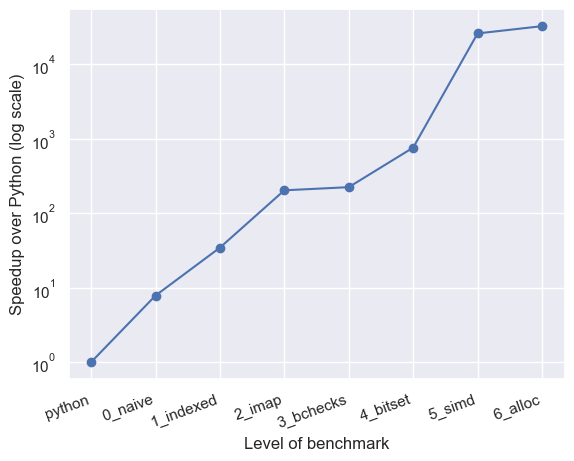

In [24]:
ax = inner_metrics.plot(x='level', y='abs_speedup', marker='o', rot=20)

plt.xticks(ha='right')
plt.yscale('log')
# ax.set_title('Performance trend across the n-CorrSet benchmark')
ax.set_xlabel('Level of benchmark')
ax.set_ylabel('Speedup over Python (log scale)')
ax.get_legend().remove()

plt.savefig('speedup.svg', bbox_inches='tight', dpi=300)

In [26]:
est_total_time_outer = lambda runtime: 2535650040 / 5_000_000 * runtime
outer_metrics = load_metrics(OUTER_DIR, OUTER_LEVELS, est_total_time_outer)
print_table(outer_metrics)

| level      | runtime_fmt   | rel_speedup_fmt   | abs_speedup_fmt   | est_total_time_fmt   |
|:-----------|:--------------|:------------------|:------------------|:---------------------|
| 0_serial   | 7.01 s        | nan×              | nan×              | 59.29 min            |
| 1_parallel | 4.18 s        | 1.68×             | 1.68×             | 35.35 min            |
| 2_batched  | 994.53 ms     | 4.21×             | 7.05×             | 8.41 min             |
